In [40]:
import networkx as nx
import random
import xml.etree.cElementTree as et
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from networkx.algorithms import bipartite
import json
import random
from sklearn import metrics
from collections import deque
import pandas as pd

In [41]:
tree=et.parse('./davis.xml')
root=tree.getroot()

Agent = []
Event = []
Edges = []



# Extract agent & event from XML file

In [42]:
for nodes in root.iter('nodeclass'):
    if(nodes.get('id') == 'agent'):
        for x in nodes:
            Agent.append(x.get('id'))
    if(nodes.get('id') == 'event'):
        for x in nodes:
            Event.append(x.get('id'))

# Extract edge pairs from XML file


In [43]:
for networks in root.iter('networks'):
    for network in networks: 
        for links in network:
            source = links.get('source')
            target = links.get('target')
            value = links.get('value')
            if(value == "1.0000"):
                Edges.append((source,target))

In [44]:
is_swapped = False
if len(Event) < len(Agent):
  temp = Agent.copy()
  Agent = Event.copy()
  Event = temp.copy()
  is_swapped = True

original_agent = Agent.copy()
original_event = Event.copy()
AGENT_MAP = {}
EVENT_MAP = {}
EDGES_MAP = {}
offset = len(Agent)

for idx, x in enumerate(Agent):
  AGENT_MAP[x] = idx
  Agent[idx] = idx
print(AGENT_MAP)

for idx, x in enumerate(Event):
  EVENT_MAP[x] = idx + offset
  Event[idx] = idx + offset
print(EVENT_MAP)

for idx, x in enumerate(Edges):
  if is_swapped:
    Edges[idx] = (EVENT_MAP[x[0]], AGENT_MAP[x[1]])
  else:
    Edges[idx] = (AGENT_MAP[x[0]], EVENT_MAP[x[1]])

print(Agent)
print(Event)
print(Edges)
print(len(Edges))

{'E1': 0, 'E2': 1, 'E3': 2, 'E4': 3, 'E5': 4, 'E6': 5, 'E7': 6, 'E8': 7, 'E9': 8, 'E10': 9, 'E11': 10, 'E12': 11, 'E13': 12, 'E14': 13}
{'EVELYN': 14, 'LAURA': 15, 'THERESA': 16, 'BRENDA': 17, 'CHARLOTTE': 18, 'FRANCES': 19, 'ELEANOR': 20, 'PEARL': 21, 'RUTH': 22, 'VERNE': 23, 'MYRNA': 24, 'KATHERINE': 25, 'SYLVIA': 26, 'NORA': 27, 'HELEN': 28, 'DOROTHY': 29, 'OLIVIA': 30, 'FLORA': 31}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[(14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 7), (14, 8), (15, 0), (15, 1), (15, 2), (15, 4), (15, 5), (15, 6), (15, 7), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (17, 0), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (18, 2), (18, 3), (18, 4), (18, 6), (19, 2), (19, 4), (19, 5), (19, 7), (20, 4), (20, 5), (20, 6), (20, 7), (21, 5), (21, 7), (21, 8), (22, 4), (22, 6), (22, 7), (22, 8), (23, 6), (23, 7), (23, 8), (23, 11), (24, 7), (24

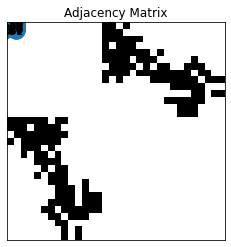

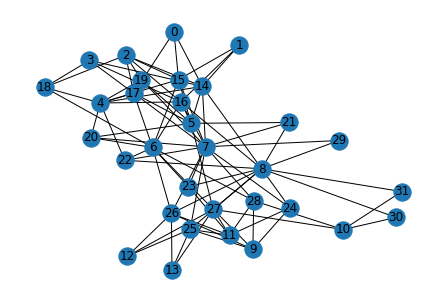

In [45]:
GRAPH = nx.Graph()

GRAPH.add_nodes_from(Agent, bipartite=0)
GRAPH.add_nodes_from(Event, bipartite=1)


GRAPH.add_edges_from(Edges)
bipartite.is_bipartite(GRAPH)
nx.draw_networkx(GRAPH, pos = nx.drawing.layout.bipartite_layout(GRAPH, Agent), width = 2)

# get adjacency matrix
adj = nx.adjacency_matrix(GRAPH)
adj = adj.toarray()
# for x in adj:
#     for v in x:
#         print(v, end=" ")
#     print("\n")

U_NODES = Agent
V_NODES = Event

# plot adjacency matrix
plt.title('Adjacency Matrix')
plt.imshow(adj, cmap='Greys')
plt.show()

# plot graph visualisation
nx.draw(GRAPH, with_labels=True)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
{14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Graph with 32 nodes and 89 edges


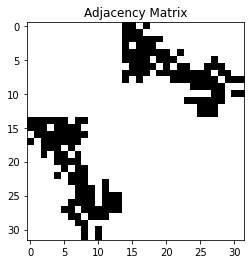

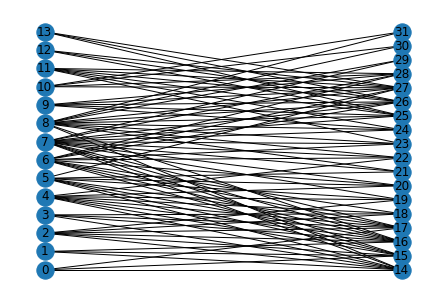

In [46]:
# create random graph
# SMALL_GRAPH = nx.bipartite.gnmk_random_graph(6, 5, 13, seed=122)
# GRAPH = SMALL_GRAPH

# get layout
U_NODES = nx.bipartite.sets(GRAPH)[0]
V_NODES = nx.bipartite.sets(GRAPH)[1]
print(U_NODES)
print(V_NODES)
pos = nx.bipartite_layout(GRAPH, U_NODES)

# get adjacency matrix
adj = nx.adjacency_matrix(GRAPH)
adj = adj.toarray()
print(GRAPH)
# plot adjacency matrix
plt.title('Adjacency Matrix')
plt.imshow(adj, cmap='Greys')
plt.show()

# plot graph visualisation
nx.draw(GRAPH, pos, with_labels=True)

### ALGORITHM: -

In [47]:
def PLP_ALGO1(GRAPH):
    global Agent
    global Event
    # Construct the set of all patterns
    U_PROJ_PAIRS = []

    for B in U_NODES:
        temp = [n for n in GRAPH.neighbors(B)]
        for x in temp:
            temp1 = [n for n in GRAPH.neighbors(x)]
            for C in temp1:
                if B != C and (C, B) not in U_PROJ_PAIRS and (B, C) not in U_PROJ_PAIRS:
                    U_PROJ_PAIRS.append((B, C))

    U_PROJ_PAIRS = set(U_PROJ_PAIRS)
        

    # Calculate the weight of each pattern
    weight = {}
    for pair in U_PROJ_PAIRS:
        A = pair[0]
        B = pair[1]
        
        deg_A = GRAPH.degree(A)
        deg_B = GRAPH.degree(B)
        
        neighbour_A = []
        neighbour_B = []
        for i in GRAPH.neighbors(A):
            neighbour_A.append(i)
        for i in GRAPH.neighbors(B):
            neighbour_B.append(i)

        neightbour_intersect = list(set(neighbour_A).intersection(neighbour_B))
        sum = 0
        for intersect in neightbour_intersect:
            sum += 1/(GRAPH.degree(intersect)+1)

        weight[pair] = sum * (2/(deg_A+deg_B))

    # print(weight, sep="\n")
    # print(len(weight))


    # U PROJECTED GRAPH

    U_PROJ_GRAPH = nx.projected_graph(GRAPH, U_NODES)

    # get adjacency matrix
    adj = nx.adjacency_matrix(U_PROJ_GRAPH)
    adj = adj.toarray()

    # plot adjacency matrix
    plt.title('Projected Graph Adjacency Matrix')
    plt.imshow(adj, cmap='Greys')
    plt.show()

    # # plot graph visualisation
    # plt.figure(figsize=(10,10)) 
    # plt.title("Projected Graph")
    # nx.draw(U_PROJ_GRAPH, with_labels=True)
    # plt.show()

    # Calculate the connectivity of CNPs
    U_PROJ_GRAPH_NODES = U_PROJ_GRAPH.nodes()
    mat = {}
    linked_mat = {}

    for node in U_PROJ_GRAPH_NODES:
        for nbr in U_PROJ_GRAPH.neighbors(node):
            for nbrNode in GRAPH.neighbors(nbr):
                bipartiteNodeNeighbors = []

                for node_neighbour in GRAPH.neighbors(node):
                    bipartiteNodeNeighbors.append(node_neighbour)

                CNP = (node, nbrNode)
                if nbrNode not in bipartiteNodeNeighbors:

                    if mat.get(CNP) is None:
                        mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    mat[CNP] = mat.get(CNP) + weight.get((node, nbr))
                else:
                    if linked_mat.get(CNP) is None:
                        linked_mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    linked_mat[CNP] = linked_mat.get(CNP) + weight.get((node, nbr))



    keys = list(mat.keys())
    values = list(mat.values())
    sorted_value_index = np.argsort(values)
    sorted_mat = {keys[i]: values[i] for i in sorted_value_index}

    FINAL_RESULT = []
    RESULT_IMP = []
    sum = 0

    for pr in sorted_mat:
        temp = {}
        temp[(original_agent[pr[0]], original_event[pr[1] - offset])] = sorted_mat[pr]
        RESULT_IMP.append((pr[0], pr[1], sorted_mat[pr]))
        FINAL_RESULT.append(temp)
        sum += sorted_mat[pr]

    FINAL_RESULT.reverse()
    RESULT_IMP.reverse()

    if is_swapped:
        temp = Agent.copy()
        Agent = Event.copy()
        Event = temp.copy()

    
    # print("total Predictions: ", FINAL_RESULT)
    # print("Top 10 predictions: ", FINAL_RESULT[:10])
    return [RESULT_IMP, FINAL_RESULT, mat, linked_mat]

In [48]:
def PLP_ALGO2(GRAPH):
    global Agent
    global Event
    # Construct the set of all patterns
    U_PROJ_PAIRS = []
    adj = nx.adjacency_matrix(GRAPH)
    adj = adj.toarray()

    for B in U_NODES:
        temp = [n for n in GRAPH.neighbors(B)]
        for x in temp:
            temp1 = [n for n in GRAPH.neighbors(x)]
            for C in temp1:
                if B != C and (C, B) not in U_PROJ_PAIRS and (B, C) not in U_PROJ_PAIRS:
                    U_PROJ_PAIRS.append((B, C))

    U_PROJ_PAIRS = set(U_PROJ_PAIRS)


    # adjList :)
    adjList = [[] for i in range(len(U_NODES) + len(V_NODES) + 300)]

    for node in U_NODES:
        for nbr in adj[node]:
            if not nbr:
                continue
            adjList[node].append(nbr)

    for node in V_NODES:
        for nbr in adj[node]:
            if not nbr:
                continue
            adjList[node].append(nbr)


    def dfs(depth, node, V, maxDepth):
        if V[node]:
            return 0
        qu = deque()
        qu.append(node)
        V[node] = True
        res = 1
        while not qu and depth <= maxDepth:
            sz = len(qu)

            for i in range(sz):
                front = qu.popleft()
                V[front] = 1
                for nbr in adjList[front]:
                    if V[nbr]:
                        continue
                    if depth%2 != 0:
                        res += 1
                    qu.append(nbr)

            depth += 1

        return res
                

    # Calculate the weight of each pattern
    weight = {}
    for pair in U_PROJ_PAIRS:
        A = pair[0]
        B = pair[1]
        
        deg_A = GRAPH.degree(A)
        deg_B = GRAPH.degree(B)
        
        neighbour_A = []
        neighbour_B = []
        for i in GRAPH.neighbors(A):
            neighbour_A.append(i)
        for i in GRAPH.neighbors(B):
            neighbour_B.append(i)

        neightbour_intersect = list(set(neighbour_A).intersection(neighbour_B))
        sum = 0
        maxi = 0
        V = [False for i in range(len(U_NODES) + len(V_NODES) + 300)]
        for intersect in neightbour_intersect:
            V[A] = True
            V[B] = True
            maxDepth = 30
            denom = dfs(0, intersect, V, maxDepth) + 2
            sum = sum + 1/denom
            maxi = max(maxi, sum)
        sum = sum%(maxi+1)
        # print("sum: ", sum, sep="\n")
        weight[pair] = maxi * (2/(deg_A+deg_B))

    # print(weight, sep="\n")
    # print(len(weight))


    # U PROJECTED GRAPH

    U_PROJ_GRAPH = nx.projected_graph(GRAPH, U_NODES)

    # get adjacency matrix
    adj = nx.adjacency_matrix(U_PROJ_GRAPH)
    adj = adj.toarray()
    
    # # plot adjacency matrix
    # plt.title(' Adjacency Matrix')
    # plt.imshow(adj, cmap='Greys')
    # plt.show()

    # # plot graph visualisation
    # plt.figure(figsize=(10,10)) 
    # plt.title("Projected Graph")
    # nx.draw(U_PROJ_GRAPH, with_labels=True)
    # plt.show()


    # Calculate the connectivity of CNPs
    U_PROJ_GRAPH_NODES = U_PROJ_GRAPH.nodes()
    mat = {}
    linked_mat = {}

    for node in U_PROJ_GRAPH_NODES:
        for nbr in U_PROJ_GRAPH.neighbors(node):
            for nbrNode in GRAPH.neighbors(nbr):
                bipartiteNodeNeighbors = []

                for node_neighbour in GRAPH.neighbors(node):
                    bipartiteNodeNeighbors.append(node_neighbour)

                CNP = (node, nbrNode)
                if nbrNode not in bipartiteNodeNeighbors:

                    if mat.get(CNP) is None:
                        mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    mat[CNP] = mat.get(CNP) + weight.get((node, nbr))
                else:
                    if linked_mat.get(CNP) is None:
                        linked_mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    linked_mat[CNP] = linked_mat.get(CNP) + weight.get((node, nbr))



    keys = list(mat.keys())
    values = list(mat.values())
    sorted_value_index = np.argsort(values)
    sorted_mat = {keys[i]: values[i] for i in sorted_value_index}

    FINAL_RESULT = []
    RESULT_IMP = []
    sum = 0

    for pr in sorted_mat:
        temp = {}
        temp[(original_agent[pr[0]], original_event[pr[1] - offset])] = sorted_mat[pr]
        RESULT_IMP.append((pr[0], pr[1], sorted_mat[pr]))
        FINAL_RESULT.append(temp)
        sum += sorted_mat[pr]

    FINAL_RESULT.reverse()
    RESULT_IMP.reverse()

    if is_swapped:
        temp = Agent.copy()
        Agent = Event.copy()
        Event = temp.copy()

    
    # print("total Predictions: ", FINAL_RESULT)
    # print("Top 10 predictions: ", FINAL_RESULT[:10])
    return [RESULT_IMP, FINAL_RESULT, mat, linked_mat]

In [49]:
def evaluate_link_prediction(pred, train_G, test_G, k=10):
    # Create arrays of true labels (y_true) and predicted scores (y_score)
    y_true = [test_G.has_edge(p[0], p[1]) for p in pred]
    y_score = [p[2] for p in pred]

    # Compute AUC-ROC score
    auc_roc = metrics.roc_auc_score(y_true, y_score) 

    # Compute AUC-PRC score
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_score)
    auc_prc = metrics.auc(recall, precision)

    # Compute precision at k
    y_pred = [1 if p[2] > thresholds[k] else 0 for p in pred]
    precision_at_k = metrics.precision_score(y_true, y_pred)

    # Compute F1 score
    f1_score = metrics.f1_score(y_true, y_pred)

    # Print evaluation metrics
    print("AUC-ROC score: {:.4f}".format(auc_roc))
    print("AUC-PRC score: {:.4f}".format(auc_prc))
    print("Precision at k = {}: {:.4f}".format(k, precision_at_k))
    print("F1 score: {:.4f}".format(f1_score))

    # Plot auc roc graph
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.plot(recall, precision)
    ax1.set_title("Precision-Recall Curve")
    # plt.title('Precision-Recall Curve')

    # Compute AUC-ROC score
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score) 
    ax2.plot(fpr, tpr)
    ax2.set_title("ROC Curve, AUC = {:.2f}".format(auc_roc))
    plt.show()

    return auc_roc, auc_prc, precision_at_k, f1_score

In [50]:
def RUN(data1, data2, idx):
    # Remove 30% of the edges
    proportion_edges = 0.3
    # this is our test set
    edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))
    # Create a copy of the graph and remove the edges
    G_train = GRAPH.copy()
    G_train.remove_edges_from(edge_subset)

    # adjacency matrix
    A_train = nx.adjacency_matrix(G_train)
    A_train = A_train.toarray()

    plt.figure(figsize=(10,10)) 
    plt.title("Train Graph")
    nx.draw(G_train, pos, with_labels=True)
    plt.show()

    """
    TEST
    """
    G_test = nx.Graph()
    G_test.add_edges_from(edge_subset)

    plt.figure(figsize=(10,10)) 
    plt.title("Test Graph")
    nx.draw(G_test, pos, with_labels=True)
    plt.show()


    G_pred = nx.Graph()
    [RESULT1, FINAL_RESULT1, mat, linked_mat] = PLP_ALGO1(G_train)
    [RESULT2, FINAL_RESULT2, mat, linked_mat] = PLP_ALGO2(G_train)
    print(FINAL_RESULT1 == FINAL_RESULT2, RESULT1 == RESULT2)

    G_pred.add_weighted_edges_from(RESULT1)
    G_pred.add_weighted_edges_from(RESULT2)

    print("for algo1: -", sep="\n")
    [auc_roc1, auc_prc1, precision_at_k1, f1_score1] = evaluate_link_prediction(RESULT1, G_train, G_test, 3)
    print("for algo2: -", sep="\n")
    [auc_roc2, auc_prc2, precision_at_k2, f1_score2] = evaluate_link_prediction(RESULT2, G_train, G_test, 3)
    
    data1["auc_roc"].append(auc_roc1 * 100)
    data1["auc_prc"].append(auc_prc1 * 100)
    
    data2["auc_roc"].append(auc_roc2 * 100)
    data2["auc_prc"].append(auc_prc2 * 100)
    
    
    # TOP_N_PREDICTIONS1 = top_n_predictions(5, FINAL_RESULT1)
    # TOP_N_PREDICTIONS2 = top_n_predictions(5, FINAL_RESULT2)

    # file_name1 = "results_predictions_algo1/result{}.json".format(idx)
    # f = open(file_name1, "w")
    
    # # Serializing json  
    # TOP_N_PREDICTIONS1 = json.dumps(TOP_N_PREDICTIONS1, indent = 4) 
    # f.write(TOP_N_PREDICTIONS1)

    # file_name2 = "results_predictions_algo2/result{}.json".format(idx)
    # f = open(file_name2, "w")
    
    # # Serializing json  
    # TOP_N_PREDICTIONS2 = json.dumps(TOP_N_PREDICTIONS2, indent = 4) 
    # f.write(TOP_N_PREDICTIONS2)



    # PREDICTIONS_ABOVE_K1 = top_predictions_above_threshold(0.6, FINAL_RESULT1)
    # PREDICTIONS_ABOVE_K2 = top_predictions_above_threshold(0.6, FINAL_RESULT2)

    # file_name1 = "results_predictions_k_algo1/result{}.json".format(idx)
    # f = open(file_name1, "w")
    
    # # Serializing json  
    # PREDICTIONS_ABOVE_K1 = json.dumps(PREDICTIONS_ABOVE_K1, indent = 4) 
    # f.write(PREDICTIONS_ABOVE_K1)

    # file_name2 = "results_predictions_k_algo2/result{}.json".format(idx)
    # f = open(file_name2, "w")
    
    # # Serializing json  
    # PREDICTIONS_ABOVE_K2 = json.dumps(PREDICTIONS_ABOVE_K2, indent = 4) 
    # f.write(PREDICTIONS_ABOVE_K2)

    # # visualise adjacency matrix
    # Apred = nx.adjacency_matrix(G_pred)
    # Apred = Apred.toarray()
    # plt.imshow(Apredcmaps, cmap='Greys')
    # plt.show()


    # plt.figure(figsize=(10,10)) 
    # plt.title("Prediction Graph")
    # nx.draw(G_pred, pos, with_labels=True)
    # plt.show()

1


C:\Users\Siddharth\AppData\Local\Temp\ipykernel_1364\1573229977.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))


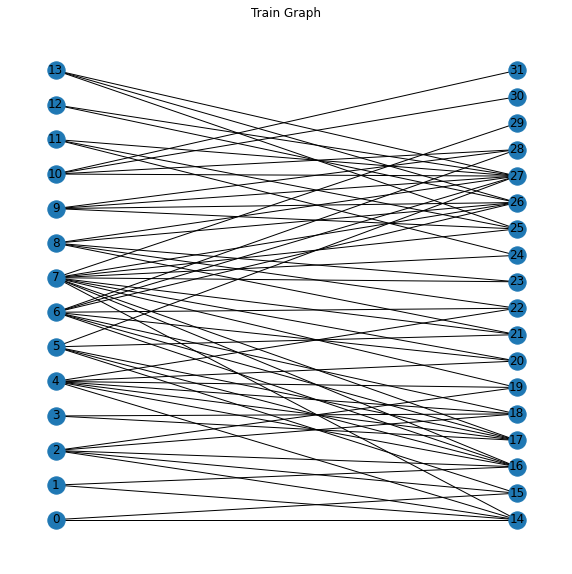

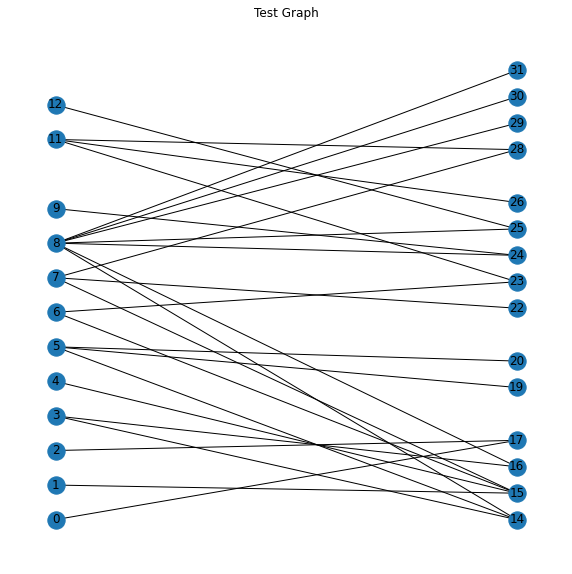

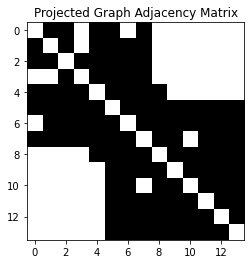

False False
for algo1: -
AUC-ROC score: 0.6016
AUC-PRC score: 0.2218
Precision at k = 3: 0.1882
F1 score: 0.2883


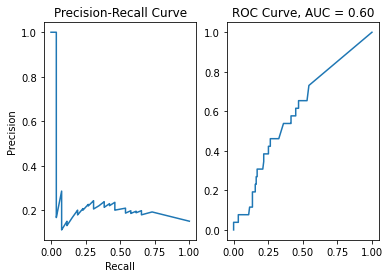

for algo2: -
AUC-ROC score: 0.6105
AUC-PRC score: 0.2311
Precision at k = 3: 0.2024
F1 score: 0.3091


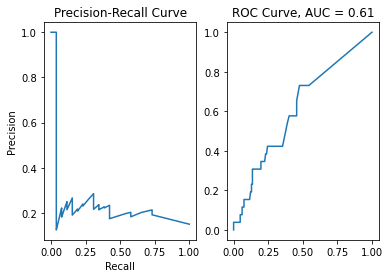

----------------------------------------END----------------------------------------

2


C:\Users\Siddharth\AppData\Local\Temp\ipykernel_1364\1573229977.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))


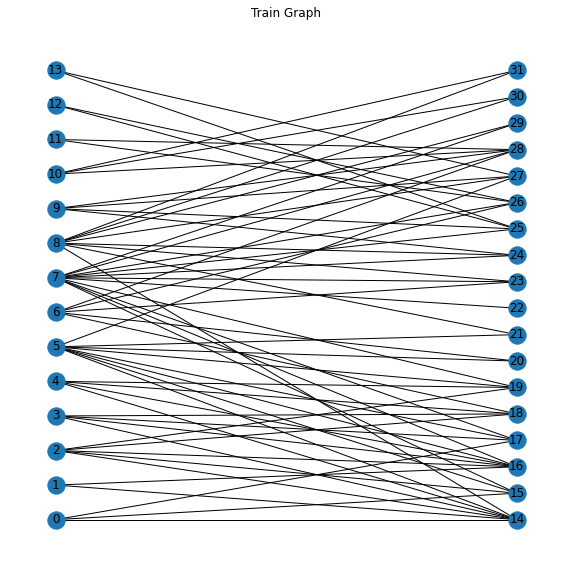

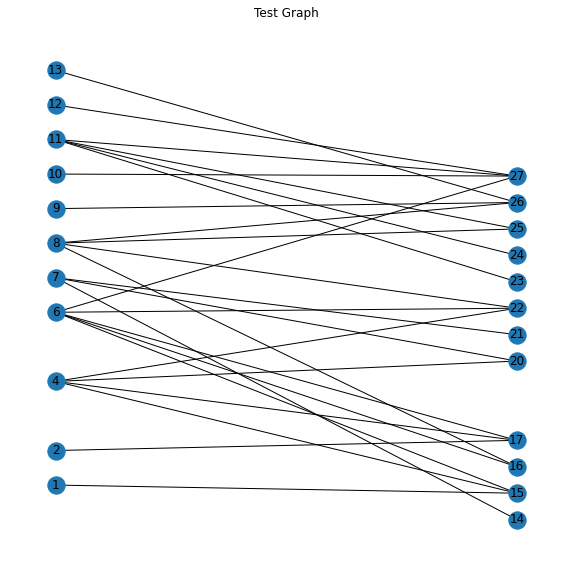

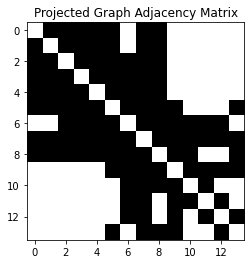

False False
for algo1: -
AUC-ROC score: 0.5756
AUC-PRC score: 0.1737
Precision at k = 3: 0.1735
F1 score: 0.2742


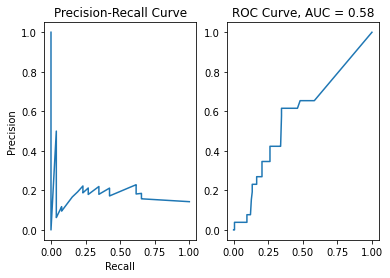

for algo2: -
AUC-ROC score: 0.5526
AUC-PRC score: 0.1598
Precision at k = 3: 0.1828
F1 score: 0.2857


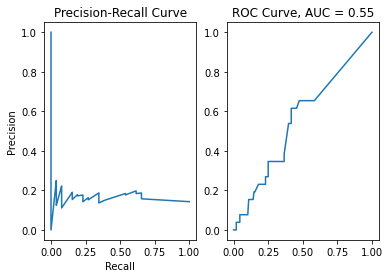

----------------------------------------END----------------------------------------

3


C:\Users\Siddharth\AppData\Local\Temp\ipykernel_1364\1573229977.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))


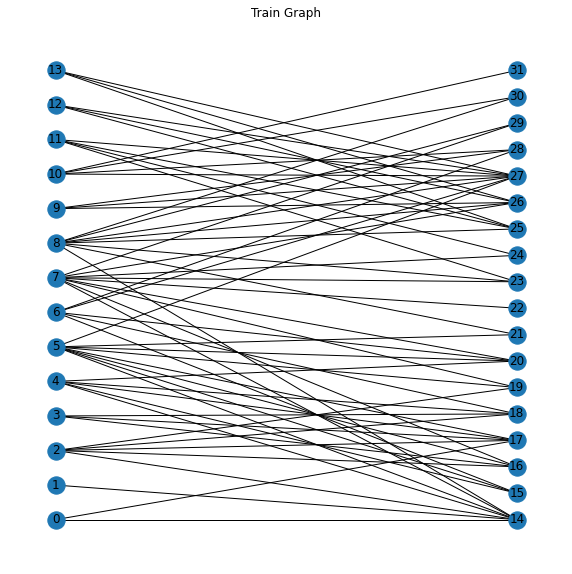

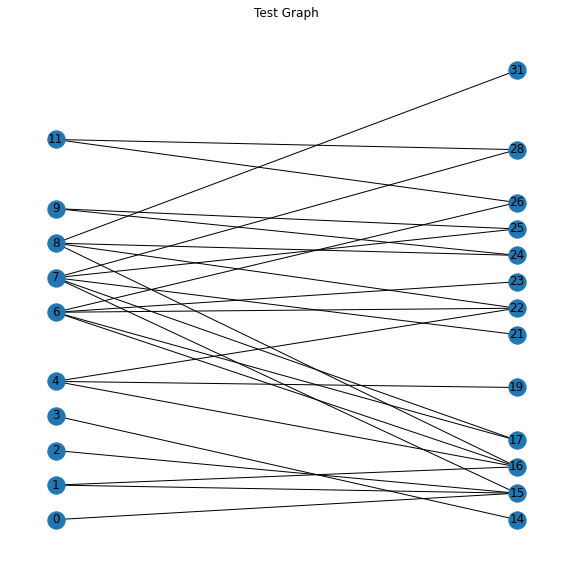

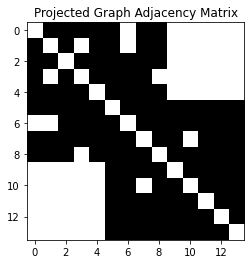

False False
for algo1: -
AUC-ROC score: 0.6608
AUC-PRC score: 0.2458
Precision at k = 3: 0.2020
F1 score: 0.3200


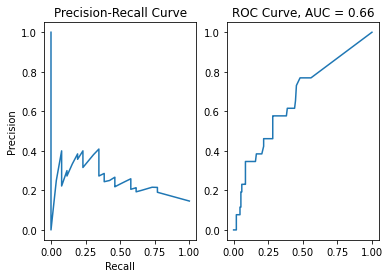

for algo2: -
AUC-ROC score: 0.6508
AUC-PRC score: 0.2477
Precision at k = 3: 0.1889
F1 score: 0.2931


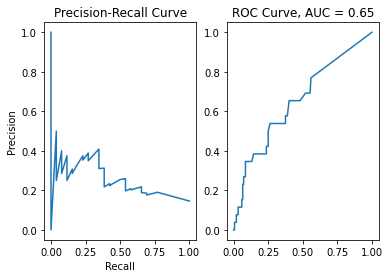

----------------------------------------END----------------------------------------



In [51]:
# df1 = pd.DataFrame({'auc_roc': [], 'auc_prc': []})
# df2 = pd.DataFrame({'auc_roc': [], 'auc_prc': []})
data1 = {'auc_roc': [], 'auc_prc': []}
data2 = {'auc_roc': [], 'auc_prc': []}
for i in range(3):
    print(i+1, sep="\n")
    RUN(data1, data2, i+1)
    print("----------------------------------------END----------------------------------------\n")

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [52]:
df1


,auc_roc,auc_prc
0,60.164835,22.181801
1,57.556706,17.365707
2,66.080466,24.580490


In [53]:
df2

,auc_roc,auc_prc
0,61.054422,23.106457
1,55.263807,15.978391
2,65.080972,24.765503
